# Introduction
First iteration of Kaggle Competition "Titanic". 

The goal of the competition is to predict the survival rate of the passengers, given data from the ship archives. 

### Imports
Import libraries and write settings here.

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
## pandas_profiling is a useful tool to do the first EDA before cleaning up the data
## https://towardsdatascience.com/speed-up-your-exploratory-data-analysis-with-pandas-profiling-88b33dc53625
from pandas_profiling import ProfileReport
import string

# Statistics and model training
import statistics as stat

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix


plt.style.use('ggplot')

# Analysis/Modeling


### Data set dictionary

link: https://www.kaggle.com/c/titanic/data

- Survived => categorical, Yes = 1, No = 0
- pclass => class of the passenger, in particular ticket class (1st = Upper 2nd = Middle 3rd = Lower)
- sex 
- age (in years) (Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5)
- sibsp => number of spouses/siblings on board (absolute count, finite)
- parch => number of parent, children on board (absolute count, finite)
- ticket => ticket id
- fare => passenger fare
- cabin number
- Embarked => port at which the passnger boarded (C = Cherbourg, Q = Queenstown, S = Southampton)

### EDA

In [2]:
# load data
train_wd = pd.read_csv('titanic_train.csv')

test_wd = pd.read_csv('titanic_test.csv')

In [3]:

# descriptive stats and info
train_wd.head()

train_wd.describe()

train_wd.info()

train_wd.shape

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


(891, 12)

In [4]:
# here we use pandas_profiling to generate an initial eda report
profile = ProfileReport(train_wd)

profile.to_notebook_iframe()

Something that I understood while continuing with the data processing is that the profile_reporting is something useful if you are already familiar with the data and the subject. In this case, it is much more useful to do the analysis myself because I need to understand the data better and deeply. Thus, let's start!

# EDA & Data Processing

### Defining some utility function

Here we want to define some functions that will help during the EDA and Data processing steps

In [5]:
# maps columns
def map_dfs(col, mapping):
    train_wd[col] = train_wd[col].map(mapping)
    test_wd[col] = test_wd[col].map(mapping)

# apply func to columns for obtaining new one
def apply_to_dfs(col, new_col, func):
    train_wd[new_col] = train_wd[col].apply(func)
    test_wd[new_col] = test_wd[col].apply(func)

# fill NaNs with mean
def fill_mean(feat):
    train_wd[feat].fillna(train_wd[feat].mean(), inplace=True)
    test_wd[feat].fillna(test_wd[feat].mean(), inplace=True)
    
# drop column
def drop(col, only_train=False):
    train_wd.drop(columns=[col], inplace=True)
    if not only_train:
        test_wd.drop(columns=[col], inplace=True)

# perform One Hot Encoding on Categorical Variables
# perform OHE
def make_dummies(feat):
    global train_wd
    global test_wd
    
    dum_train = pd.get_dummies(train_wd[feat], prefix=feat, drop_first=True)
    dum_test = pd.get_dummies(test_wd[feat], prefix=feat, drop_first=True)
    
    common_columns = [i for i in dum_train.columns if i in dum_test.columns]
    remove_train = [i for i in dum_train.columns if i not in common_columns]
    remove_test = [i for i in dum_test.columns if i not in common_columns]
    
    train_wd = pd.concat([train_wd, dum_train[common_columns]], axis=1)
    train_wd.drop(columns=[feat], inplace=True)
    test_wd = pd.concat([test_wd, dum_test[common_columns]], axis=1)
    test_wd.drop(columns=[feat], inplace=True)
    
# plot correlation matrix
def plot_corr(df):
    plt.figure(1, figsize=(16, 16))
    sns.heatmap(df.corr(), annot=True, fmt='.2f', cbar=False)
    plt.show()

We will evaluate each feature and evaluate the additional value that they can bring to the final model. We will do some Exploratory analysis on current feature and some feature engineering.

In [6]:
# quickly rename all columns to lower case strings
train_wd.columns = map(str.lower, train_wd.columns)

test_wd.columns = map(str.lower, test_wd.columns)

train_wd.head()

passengerid  survived  pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                name     sex   age  sibsp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   parch            ticket     fare cabin embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

## Feature exploration - Age and Name

Staring with Age, we have 17% of missing values. We can try using multiple approaches to avoid dropping these values and losing this information. We will create additional columns for each approaches and test which result in a better performance of the model. 

- Substitute the missing with the statistics (mean, median) based on the port of embark
- Substitute missing values based on the inferred salutation of the name, where available

Since we are addressing the name variable now, I'll perform some additional manipulation to split the name into its name building blocks. 

We recognize that the name has this format: {last_name}, {salutation}, {remaining_name}. I will extract this information.

In [7]:
# Defining functions to reduce the name variable into its building blocks

def extract_salutation(name):
    '''
    Split the name into its pieces. We get the salutation after the last name and coma.
    '''
    if ',' not in name:
        return 'outlier'
    else:
        after_comma = name.split(',')[1][1:]
        return after_comma.split('.')[0] if '.' in after_comma else '$'

def extract_last_name(name):
    '''
    Split the name into its pieces. We get the last name.
    '''
    return name.split(',')[0] if ',' in name else '$'

def extract_remaining_name(name):
    return name.split('.')[1] if '.' in name else '$'

apply_to_dfs('name', 'salutation', extract_salutation)

apply_to_dfs('name', 'last_name', extract_last_name)

apply_to_dfs('name', 'rem_name', extract_remaining_name)

train_wd.head()

passengerid  survived  pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                name     sex   age  sibsp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   parch            ticket     fare cabin embarked salutation  last_name  \
0      0         A/5 21171   7.2500   NaN        S         Mr     Braund   
1      0          PC 17599  71.2833   C85        C        Mrs    Cumings   
2      0  STON/O2. 3101282   7.9250   NaN        S       Miss  Heikkinen   
3      0            113803  53.1000  C123        S        Mrs   Futrelle   
4      0            373450   8.0500   NaN        S         Mr      Allen   

                                 rem_name  
0                             Owen Harris  
1   John Bradley (Florence Briggs Thayer)  
2                                   Laina  
3           Jacques Heath (Lily May Peel)  
4                           William Henry

We can extract additional details from the remaining_name column and see wether there is a correlation between survival rate and additional details. 

In [8]:
# extracting additional details from remaining part of the names
apply_to_dfs('rem_name', 'name_words_count', lambda name: len(name.split()) + 1)

apply_to_dfs('rem_name', 'has_brakets', lambda name: 1 if '(' in name else 0)

apply_to_dfs('rem_name', 'has_quot', lambda name: 1 if '"' in name else 0)

train_wd.head()

passengerid  survived  pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                name     sex   age  sibsp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   parch            ticket     fare cabin embarked salutation  last_name  \
0      0         A/5 21171   7.2500   NaN        S         Mr     Braund   
1      0          PC 17599  71.2833   C85        C        Mrs    Cumings   
2      0  STON/O2. 3101282   7.9250   NaN        S       Miss  Heikkinen   
3      0            113803  53.1000  C123        S        Mrs   Futrelle   
4      0            373450   8.0500   NaN        S         Mr      Allen   

                                 rem_name  name_words_count  has_brakets  \
0                             Owen Harris                 3            0   
1   John Bradley (Florence Briggs Thayer)                 6            1   
2                                   Laina                 2            0   
3           Jacques Heath (Lily May Peel)                 6            1   
4                           William Henry                 3            0   

   has_quot  
0         0  
1         0  
2         0  
3         0  
4         0

We can now cluster the number of people in the family using the Last name we just extracted. This information is also contained in the columns sibsp and parch. However, we can evaluate how many family members survived. This can give us an additional information on the survival rate if passengers were alone of travelling in groups. 

In [9]:
# generate a temp dataframe with survival rate by family last name
fam_surv_rate = train_wd.groupby('last_name')['survived'].agg(['sum', 'count'])

# survival rate is number of family members survived over total family members
fam_surv_rate['survival_rate'] = fam_surv_rate['sum'] / fam_surv_rate['count']

fam_surv_rate.head()

sum  count  survival_rate
last_name                           
Abbing       0      1            0.0
Abbott       1      2            0.5
Abelson      1      2            0.5
Adahl        0      1            0.0
Adams        0      1            0.0

We can now map the survival rate to the datasets

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
passengerid         891 non-null int64
survived            891 non-null int64
pclass              891 non-null int64
name                891 non-null object
sex                 891 non-null object
age                 714 non-null float64
sibsp               891 non-null int64
parch               891 non-null int64
ticket              891 non-null object
fare                891 non-null float64
cabin               204 non-null object
embarked            889 non-null object
salutation          891 non-null object
last_name           891 non-null object
rem_name            891 non-null object
name_words_count    891 non-null int64
has_brakets         891 non-null int64
has_quot            891 non-null int64
survival_rate       891 non-null float64
dtypes: float64(3), int64(8), object(8)
memory usage: 132.4+ KB


<Figure size 720x432 with 0 Axes>

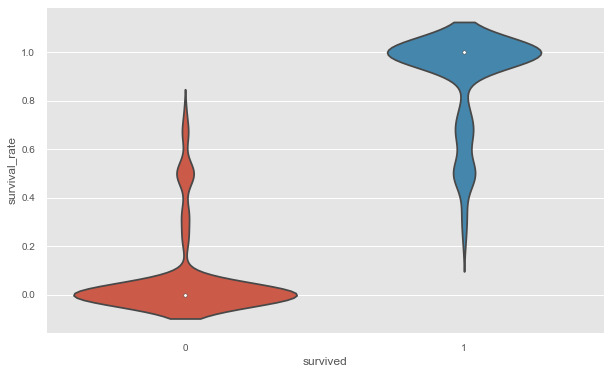

In [10]:
# here we apply a 50% chance of survival to passengers that we are not able to evaluate using our family member survival rate
for i in range(train_wd.shape[0]):
    last_name = train_wd.iloc[i]['last_name']
    if last_name in fam_surv_rate.index:
        #get the positional value and set it to the value of the survival_rate data frame if present
        train_wd.at[i, 'survival_rate'] = fam_surv_rate.loc[last_name]['survival_rate']
    else:
        # else match a 50% survival rate (i.e. chance)
        train_wd.at[i, 'survival_rate'] =  0.5

for i in range(test_wd.shape[0]):
    last_name = test_wd.iloc[i]['last_name']
    if last_name in fam_surv_rate.index:
        #get the positional value and set it to the value of the survival_rate data frame if present
        test_wd.at[i, 'survival_rate'] = fam_surv_rate.loc[last_name]['survival_rate']
    else:
        # else match a 50% survival rate (i.e. chance)
        test_wd.at[i, 'survival_rate'] =  0.5

train_wd.info()

plt.figure(1, figsize=(10, 6))
sns.violinplot(x='survived', y='survival_rate', data=train_wd)
plt.show()

<Figure size 1152x864 with 0 Axes>

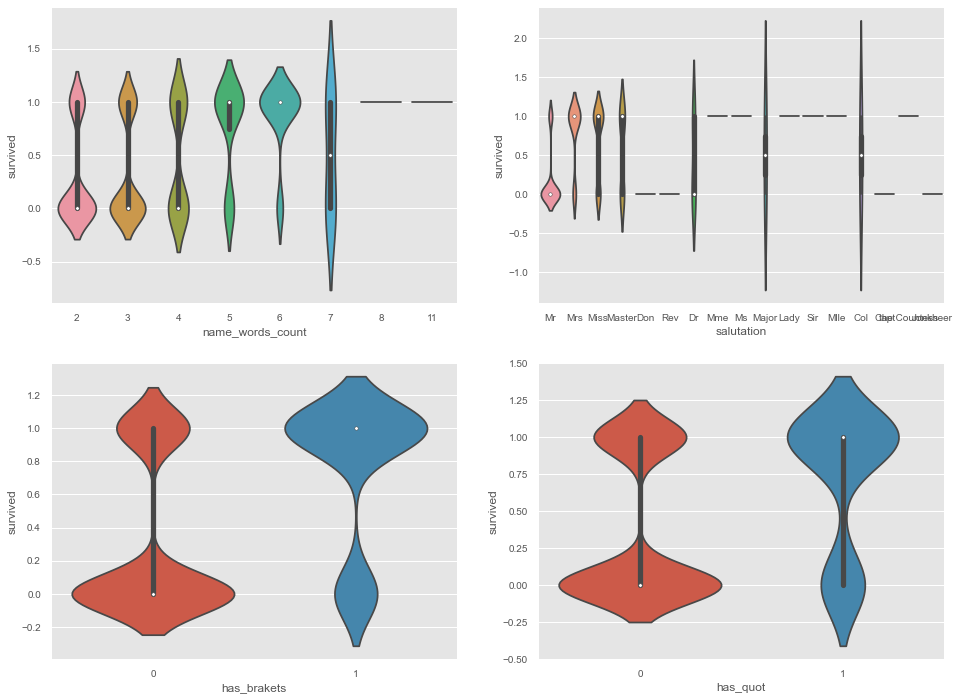

In [11]:
# Explore the distribution of name features we extracted
plt.figure(1, figsize=(16, 12))

plt.subplot(221)
sns.violinplot(x='name_words_count', y='survived', data=train_wd)

plt.subplot(222)
sns.violinplot(x='salutation', y='survived', data=train_wd)

plt.subplot(223)
sns.violinplot(x='has_brakets', y='survived', data=train_wd)

plt.subplot(224)
sns.violinplot(x='has_quot', y='survived', data=train_wd)


In [12]:
# then we want to evaluate the median values for the salutation sub-groups
salutation_labels = list(train_wd['salutation'].unique())
salutation_median = {}

# obtain the median age value by salutation
for i in salutation_labels:
    salutation_median.update({i : stat.median(train_wd[(train_wd['salutation']==i) & (train_wd['age'].notnull())]['age'])})
    
# we generate an additional column that we fill missing value for age with the median
train_wd['age_opt'] = train_wd['age'].fillna(train_wd['salutation'].map(salutation_median))


train_wd.head()


passengerid  survived  pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                name     sex   age  sibsp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   parch            ticket     fare cabin embarked salutation  last_name  \
0      0         A/5 21171   7.2500   NaN        S         Mr     Braund   
1      0          PC 17599  71.2833   C85        C        Mrs    Cumings   
2      0  STON/O2. 3101282   7.9250   NaN        S       Miss  Heikkinen   
3      0            113803  53.1000  C123        S        Mrs   Futrelle   
4      0            373450   8.0500   NaN        S         Mr      Allen   

                                 rem_name  name_words_count  has_brakets  \
0                             Owen Harris                 3            0   
1   John Bradley (Florence Briggs Thayer)                 6            1   
2                                   Laina                 2            0   
3           Jacques Heath (Lily May Peel)                 6            1   
4                           William Henry                 3            0   

   has_quot  survival_rate  age_opt  
0         0            0.0     22.0  
1         0            1.0     38.0  
2         0            1.0     26.0  
3         0            0.5     35.0  
4         0            0.5     35.0

this provides more flavours to the Age group and helps in filling the nan values

## Feature Exploration - Ticket, Cabin, Fare and Embarked

Ticket and cabin numbers are variable with a lot of missing values. Since most of the folks didn't have a cabin associated, I will generate a label that uses the cabin first letter when available, thus specifying the cabin deck, or, alternatively will put unknown. 

In [13]:
# here we populate the cabin nan values with unavailable else with the first letter of the deck cabin
apply_to_dfs('cabin', 'cabin_key', lambda c: c[0] if c == c else 'not_on_deck')


Now, we should try to use the ticket number and the fare to evaluate if there are groups that travelled together. Probably, this would match with cabin purchased closer to each other. 

In [14]:
# here we generate a column to evaluate wether the titcket has a first letter (class ticket) or not
train_wd['ticket_letter'] = train_wd.ticket.astype(str).str[0].str.isalpha()

test_wd['ticket_letter'] = test_wd.ticket.astype(str).str[0].str.isalpha()


In [15]:
# we have only few missing values for Embarked. We use the mode to fill the missing 
train_wd['embarked_opt'] = train_wd.embarked.fillna('mode')
test_wd['embarked_opt'] = test_wd.embarked.fillna('mode')



In [16]:
train_wd.info()
train_wd.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 23 columns):
passengerid         891 non-null int64
survived            891 non-null int64
pclass              891 non-null int64
name                891 non-null object
sex                 891 non-null object
age                 714 non-null float64
sibsp               891 non-null int64
parch               891 non-null int64
ticket              891 non-null object
fare                891 non-null float64
cabin               204 non-null object
embarked            889 non-null object
salutation          891 non-null object
last_name           891 non-null object
rem_name            891 non-null object
name_words_count    891 non-null int64
has_brakets         891 non-null int64
has_quot            891 non-null int64
survival_rate       891 non-null float64
age_opt             891 non-null float64
cabin_key           891 non-null object
ticket_letter       891 non-null bool
embarked_opt        8

passengerid  survived  pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                name     sex   age  sibsp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   parch            ticket     fare cabin embarked salutation  last_name  \
0      0         A/5 21171   7.2500   NaN        S         Mr     Braund   
1      0          PC 17599  71.2833   C85        C        Mrs    Cumings   
2      0  STON/O2. 3101282   7.9250   NaN        S       Miss  Heikkinen   
3      0            113803  53.1000  C123        S        Mrs   Futrelle   
4      0            373450   8.0500   NaN        S         Mr      Allen   

                                 rem_name  name_words_count  has_brakets  \
0                             Owen Harris                 3            0   
1   John Bradley (Florence Briggs Thayer)                 6            1   
2                                   Laina                 2            0   
3           Jacques Heath (Lily May Peel)                 6            1   
4                           William Henry                 3            0   

   has_quot  survival_rate  age_opt    cabin_key  ticket_letter embarked_opt  
0         0            0.0     22.0  not_on_deck           True            S  
1         0            1.0     38.0            C           True            C  
2         0            1.0     26.0  not_on_deck           True            S  
3         0            0.5     35.0            C          False            S  
4         0            0.5     35.0  not_on_deck          False            S

For the cabin fare, we want to cluster by fare size. One easy quick fix to normalize the fare is to bring the fare to a log scale. We are not considering outlier for now

In [17]:
# bring the fare to a log scale
train_wd['fare_log'] = np.log1p(train_wd['fare'])

test_wd['fare_log'] = np.log1p(test_wd['fare'])

# we defined 
train_wd.groupby('fare_log')['survived'].agg('count')


fare_log
0.000000    15
1.611935     1
1.791759     1
1.979276     1
2.006535     1
            ..
5.431646     4
5.515527     2
5.573579     2
5.575949     4
6.240917     3
Name: survived, Length: 248, dtype: int64

It seems that the fare could carry some additional information. We could apply the same logic we applied to family survival rate and identify the survival rate dependency based on the ticket fare.


In [18]:
# generate a temp dataframe with survival rate by family last name
fare_surv_rate = train_wd.groupby('fare_log')['survived'].agg(['sum', 'count'])

# survival rate is number of family members survived over total family members
fare_surv_rate['survival_rate'] = fare_surv_rate['sum'] / fare_surv_rate['count']

# create new columns with 0.5 ('Name' is for stub and not used)
apply_to_dfs('fare_log', 'fare_surv_rate', lambda n: 0.5)

# here we apply a 50% chance of survival to passengers that we are not able to evaluate using our family member survival rate
for i in range(train_wd.shape[0]):
    fare_log = train_wd.iloc[i]['fare_log']
    if fare_log in fare_surv_rate.index:
        #get the positional value and set it to the value of the survival_rate data frame if present
        train_wd.at[i, 'fare_surv_rate'] = fare_surv_rate.loc[fare_log]['survival_rate']
    else:
        # else match a 50% survival rate (i.e. chance)
        train_wd.at[i, 'fare_surv_rate'] =  0.5

for i in range(test_wd.shape[0]):
    fare_log = test_wd.iloc[i]['fare_log']
    if fare_log in fare_surv_rate.index:
        #get the positional value and set it to the value of the survival_rate data frame if present
        test_wd.at[i, 'fare_surv_rate'] = fare_surv_rate.loc[fare_log]['survival_rate']
    else:
        # else match a 50% survival rate (i.e. chance)
        test_wd.at[i, 'fare_surv_rate'] =  0.5




In [19]:
# create grouping for logarithmic fare
train_wd['log_fare_below_1_5'] = train_wd['fare_log'] <1.5

train_wd['log_fare_between_1_5_and_4'] = (train_wd['fare_log'] >1.5) & (train_wd['fare_log'] < 4) 

train_wd['log_fare_higher_4'] = train_wd['fare_log'] > 4 


In [20]:
train_wd.info()
train_wd.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 28 columns):
passengerid                   891 non-null int64
survived                      891 non-null int64
pclass                        891 non-null int64
name                          891 non-null object
sex                           891 non-null object
age                           714 non-null float64
sibsp                         891 non-null int64
parch                         891 non-null int64
ticket                        891 non-null object
fare                          891 non-null float64
cabin                         204 non-null object
embarked                      889 non-null object
salutation                    891 non-null object
last_name                     891 non-null object
rem_name                      891 non-null object
name_words_count              891 non-null int64
has_brakets                   891 non-null int64
has_quot                      891 non-null int64
s

passengerid  survived  pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                name     sex   age  sibsp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   parch            ticket     fare cabin embarked salutation  last_name  \
0      0         A/5 21171   7.2500   NaN        S         Mr     Braund   
1      0          PC 17599  71.2833   C85        C        Mrs    Cumings   
2      0  STON/O2. 3101282   7.9250   NaN        S       Miss  Heikkinen   
3      0            113803  53.1000  C123        S        Mrs   Futrelle   
4      0            373450   8.0500   NaN        S         Mr      Allen   

                                 rem_name  name_words_count  has_brakets  \
0                             Owen Harris                 3            0   
1   John Bradley (Florence Briggs Thayer)                 6            1   
2                                   Laina                 2            0   
3           Jacques Heath (Lily May Peel)                 6            1   
4                           William Henry                 3            0   

   has_quot  survival_rate  age_opt    cabin_key  ticket_letter embarked_opt  \
0         0            0.0     22.0  not_on_deck           True            S   
1         0            1.0     38.0            C           True            C   
2         0            1.0     26.0  not_on_deck           True            S   
3         0            0.5     35.0            C          False            S   
4         0            0.5     35.0  not_on_deck          False            S   

   fare_log  fare_surv_rate  log_fare_below_1_5  log_fare_between_1_5_and_4  \
0  2.110213        0.076923               False                        True   
1  4.280593        1.000000               False                       False   
2  2.188856        0.444444               False                        True   
3  3.990834        0.600000               False                        True   
4  2.202765        0.116279               False                        True   

   log_fare_higher_4  
0              False  
1               True  
2              False  
3              False  
4              False

## Feature Exploration - sibsp, parch

sibsp and parch together should give us the total size of the passenger family (extended). We are going to combine these two features and then use them to classify the family clusters.

- if the sum = 0 -> the passenger is independent
- if the family size > 3 we will identify it as big_family

In [21]:
train_wd['family_size'] = train_wd['sibsp'] + train_wd['parch']
test_wd['family_size'] = test_wd['sibsp'] + test_wd['parch']

apply_to_dfs('family_size', 'independent', lambda family_size: 1 if family_size == 0 else 0)
apply_to_dfs('family_size', 'big_family', lambda family_size: 1 if family_size > 3 else 0)

train_wd.head()

passengerid  survived  pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                name     sex   age  sibsp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   parch            ticket     fare cabin embarked salutation  last_name  \
0      0         A/5 21171   7.2500   NaN        S         Mr     Braund   
1      0          PC 17599  71.2833   C85        C        Mrs    Cumings   
2      0  STON/O2. 3101282   7.9250   NaN        S       Miss  Heikkinen   
3      0            113803  53.1000  C123        S        Mrs   Futrelle   
4      0            373450   8.0500   NaN        S         Mr      Allen   

                                 rem_name  name_words_count  has_brakets  \
0                             Owen Harris                 3            0   
1   John Bradley (Florence Briggs Thayer)                 6            1   
2                                   Laina                 2            0   
3           Jacques Heath (Lily May Peel)                 6            1   
4                           William Henry                 3            0   

   has_quot  survival_rate  age_opt    cabin_key  ticket_letter embarked_opt  \
0         0            0.0     22.0  not_on_deck           True            S   
1         0            1.0     38.0            C           True            C   
2         0            1.0     26.0  not_on_deck           True            S   
3         0            0.5     35.0            C          False            S   
4         0            0.5     35.0  not_on_deck          False            S   

   fare_log  fare_surv_rate  log_fare_below_1_5  log_fare_between_1_5_and_4  \
0  2.110213        0.076923               False                        True   
1  4.280593        1.000000               False                       False   
2  2.188856        0.444444               False                        True   
3  3.990834        0.600000               False                        True   
4  2.202765        0.116279               False                        True   

   log_fare_higher_4  family_size  independent  big_family  
0              False            1            0           0  
1               True            1            0           0  
2              False            0            1           0  
3              False            1            0           0  
4              False            0            1           0

## Create Dummy variables and target variable before training


In [22]:
# Our target is "Survived". Our test ids are "PassengerIds"
target = train_wd['survived']
test_ids = test_wd['passengerid']

# generate dummies for categorical variables
make_dummies('embarked')
make_dummies('embarked_opt')
make_dummies('pclass')
make_dummies('sex')
make_dummies('ticket')
make_dummies('cabin_key')
make_dummies('salutation')

# removing IDs and Survived from training set
drop('passengerid')
drop('survived', only_train=True)
drop('name')
drop('last_name')
drop('rem_name')



train_wd.info()
train_wd.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Columns: 155 entries, age to salutation_Rev
dtypes: bool(4), float64(6), int64(8), object(1), uint8(136)
memory usage: 226.4+ KB


age  sibsp  parch     fare cabin  name_words_count  has_brakets  has_quot  \
0  22.0      1      0   7.2500   NaN                 3            0         0   
1  38.0      1      0  71.2833   C85                 6            1         0   
2  26.0      0      0   7.9250   NaN                 2            0         0   
3  35.0      1      0  53.1000  C123                 6            1         0   
4  35.0      0      0   8.0500   NaN                 3            0         0   

   survival_rate  age_opt  ticket_letter  fare_log  fare_surv_rate  \
0            0.0     22.0           True  2.110213        0.076923   
1            1.0     38.0           True  4.280593        1.000000   
2            1.0     26.0           True  2.188856        0.444444   
3            0.5     35.0          False  3.990834        0.600000   
4            0.5     35.0          False  2.202765        0.116279   

   log_fare_below_1_5  log_fare_between_1_5_and_4  log_fare_higher_4  \
0               False                        True              False   
1               False                       False               True   
2               False                        True              False   
3               False                        True              False   
4               False                        True              False   

   family_size  independent  big_family  embarked_Q  embarked_S  \
0            1            0           0           0           1   
1            1            0           0           0           0   
2            0            1           0           0           1   
3            1            0           0           0           1   
4            0            1           0           0           1   

   embarked_opt_Q  embarked_opt_S  pclass_2  pclass_3  ...  ticket_PC 17761  \
0               0               1         0         1  ...                0   
1               0               0         0         0  ...                0   
2               0               1         0         1  ...                0   
3               0               1         0         0  ...                0   
4               0               1         0         1  ...                0   

   ticket_PP 9549  ticket_S.C./PARIS 2079  ticket_S.O.C. 14879  \
0               0                       0                    0   
1               0                       0                    0   
2               0                       0                    0   
3               0                       0                    0   
4               0                       0                    0   

   ticket_SC/AH 29037  ticket_SC/AH 3085  ticket_SC/PARIS 2167  \
0                   0                  0                     0   
1                   0                  0                     0   
2                   0                  0                     0   
3                   0                  0                     0   
4                   0                  0                     0   

   ticket_SC/Paris 2123  ticket_W./C. 6607  ticket_W./C. 6608  \
0                     0                  0                  0   
1                     0                  0                  0   
2                     0                  0                  0   
3                     0                  0                  0   
4                     0                  0                  0   

   ticket_W.E.P. 5734  cabin_key_B  cabin_key_C  cabin_key_D  cabin_key_E  \
0                   0            0            0            0            0   
1                   0            0            1            0            0   
2                   0            0            0            0            0   
3                   0            0            1            0            0   
4                   0            0            0            0            0   

   cabin_key_F  cabin_key_G  cabin_key_not_on_deck  salutation_Dr  \
0            0            0                      1              0   